## Author Explorer: Let's Make Some Paper Lists!

Let's try to produce a list of interesting AI papers from some important figures in the field.

### Step 1: Examine Input Data

To do so we'll use some data that's not yet available via Semantic Scholar's public API (we're working on that). Let's take a look at the authors we have in that output:

In [1]:
import json
import pandas as pd

from IPython.display import HTML, display
from pretty_html_table import build_table

def s2_url(path: str) -> str:
    url = f"https://semanticscholar.org{path}"
    return url

def href(url: str) -> str:
    return f"<a href={url}>{url}</a>"

author_citations = json.load(open("author_citations.json", "r"))

authors = []
for id, a in author_citations.items():
    authors.append({ "id": id, "name": a["name"], "url": href(s2_url(f"/author/{id}")) })
    
adf = pd.DataFrame(authors)
display(HTML(build_table(adf, 'green_dark', escape=False)))


id,name,url
1780531,Dan Weld,https://semanticscholar.org/author/1780531
2684226,Ani Kembhavi,https://semanticscholar.org/author/2684226
1699545,Yejin Choi,https://semanticscholar.org/author/1699545
48323507,Peter Clark,https://semanticscholar.org/author/48323507
144365875,Noah Smith,https://semanticscholar.org/author/144365875
2548384,Hannaneh Hajishirzi,https://semanticscholar.org/author/2548384
1701686,Ilya Sutskever,https://semanticscholar.org/author/1701686
1695689,Geoffrey E. Hinton,https://semanticscholar.org/author/1695689
1741101,Oren Etzioni,https://semanticscholar.org/author/1741101
48004138,Li Fei-Fei,https://semanticscholar.org/author/48004138


This looks like a good set of authors to start with. Maybe we'll add more in the future, if there's interst.

### Step 2: Enrich the Data using Semantic Scholar's Public API

Next we'll go through the papers they cite the most and mix in some extra information from Semantic Scholar's API that we'll use later.

We sort each author's list of citations by the `n_citations` field. This is the number of unique papers by the author that cited the paper.

In [4]:
from typing import Optional, List, Tuple
from tqdm import tqdm
from os import path

import requests

# To avoid rate limits, create a file called key.txt with your Semantic Scholar API key 
# as the contents.
api_key = None
if path.isfile("key.txt"):
    api_key = open("key.txt").read().strip()
if api_key is not None:
    assert(api_key != "")
    print("INFO: your Semantic Scholar API key will be used.")

def get_extra_fields(sha: str) -> Tuple[str, List[float]]:
    """
    Fetch the TLDR and SPECTRE embedding. These might not exist, so we handle
    failure gracefully.
    
    The first value is the TLDR. The second is the SPECTRE embedding.
    """    
    headers = None
    if api_key is not None:
        headers = { "x-api-key": api_key }
    resp = requests.get(
        f"https://api.semanticscholar.org/graph/v1/paper/{sha}?fields=tldr,embedding",
        headers=headers,
    )
    if resp.status_code != 200:
        return ["", []]
    payload = resp.json()
    tldr = payload.get("tldr")
    embed = payload.get("embedding")
    return (
        tldr["text"] if tldr is not None else "",
        embed["vector"] if embed is not None else []
    )

# We'll keep them in a list to use later
papers = []

for id, a in tqdm(author_citations.items()):
    most_cited = sorted(a["papers"], key=lambda p : p["n_citations"], reverse=True)    
    for p in most_cited[:10]:
        tldr, embed = get_extra_fields(p["paper_sha"])
        paper = {
            "id": id,
            "sha": p["paper_sha"],
            "names": [a["name"]], 
            "author_id": id,
            "title": p["title"],
            "self_citation": p["self_cited"],
            "url": s2_url(f"/paper/{p['paper_sha']}"),
            "tldr": tldr,
            "embedding": embed,
        }
        papers.append(paper)        
        
# We don't output much, so that this cell can be cached (it's slow).
print(len(papers))


INFO: your Semantic Scholar API key will be used.


100%|█████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.14s/it]

160


160 papers are too many to display in a notebook. Clearly we need to build this into S2 instead :)

In the meantime we'll take a look at single author's list, just to see what things look like. Given this whole exercise spawned via curiosity about Ilya Sutskever's list, let's take a look at that list first.

And if [John Carmack](https://twitter.com/ID_AA_Carmack) decides to look at this, please let us know how well this aligns with the list you were given.

In [5]:
def paper_html(p, cited: bool = False) -> str:
    return f"""
        <div style="margin: 15px 0;">
            <h5 style="font-style: normal; margin: 0;">{p["title"]}</h5>            
            {'<p style="margin: 5px 0;><em>Self Citation</em></p>' if p["self_citation"] else ""}
            <p style="margin: 5px 0; display: {"none" if not cited else "block"};">
                <strong>Cited By:</strong> {", ".join(p["names"])}
            </p>
            <p style="max-width: 70ch; margin: 5px 0;">
                <span style="font-size: 12px; background: #eee; border-radius: 2px; padding: 2px 4px; line-height: 1; display: inline-block">
                    TLDR
                </span>
                <span style="font-size: 12px;">{p["tldr"]}</span>
            </p>
            <span style="font-size: 12px">
                <a href="{p["url"]}">
                    {p["url"]}
                </a>
            </span>
        </div>
    """

ilyas = [ p for p in papers if p["author_id"] == "1701686" ]
ilyas_html = "\n".join([ paper_html(p, cited=True) for p in ilyas ])
display(HTML(f"<div style='padding: 15px 0;'><{ilyas_html}</div>"))


### Step 3: Find the Intersection

But as we mentioned, we don't think Ilya's list should be too intersting in itself. There's _a lot_ going on in the field. We think it's more important for folks to consume a list that's more representative.

We can do our best to try to produce something like that by looking at papers that all of these folks cite. So let's do that by finding the intersection.

In [6]:
common = []
for sha, group in pd.DataFrame(papers).groupby("sha"):
    if len(group) == 1:
        continue
    names = set()
    paper = None
    for _, p in group.iterrows():
        paper = p
        for n in p["names"]:
            names.add(n)
    paper["names"] = list(names)
    common.append(paper)    
    
common.sort(key=lambda p : len(p["names"]), reverse=True)
list_html = "\n".join([ paper_html(p, cited=True) for p in common ])
display(HTML(f"<div style='padding: 15px 0;'>{list_html}</div>"))

This list looks more interesting to us. There's a lot of really important work captured there.

It'd be interested to assess how many of these were cited by Ilya, as a proxy for how comprehensive his list is. Let's figure that out.


In [39]:
total = len(common)

author_names = set()
for p in common:
    for n in p["names"]:
        author_names.add(n)

overlap = []
for a in list(author_names):
    count = len([p for p in common if a in p["names"]])
    overlap.append({ "name": a, "count": count, "percent": f"{count/total:.0%}" })
    
overlap.sort(key=lambda o : o["count"], reverse=True)

display(HTML(build_table(pd.DataFrame(overlap), 'blue_dark', escape=False)))


name,count,percent
R. Socher,8,33%
Ilya Sutskever,8,33%
Hannaneh Hajishirzi,8,33%
Yejin Choi,7,29%
Yoshua Bengio,6,25%
Noah Smith,5,21%
Li Fei-Fei,5,21%
Ani Kembhavi,4,17%
Peter Clark,4,17%
A. Karpathy,4,17%


Interesting. This does suggest Ilya does a good job of building off of and citing important work.

### Step 4: Similarity Analysis

We thought it'd be fun to go a step further and use the [SPECTER embeddings](https://github.com/allenai/specter) to visualize the lists of each of these offers. That'd give us some idea of how "similar" the things are that they're citing.

Let's do that next.

16it [00:04,  3.65it/s]


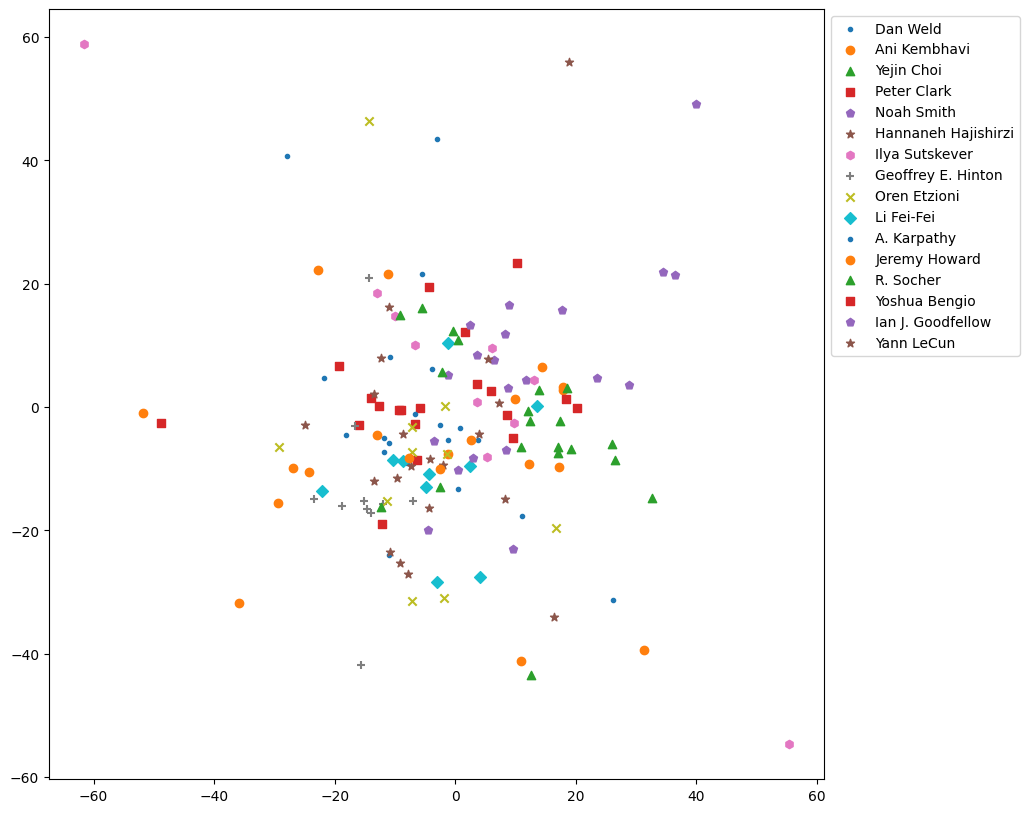

In [15]:
from sklearn import manifold

import matplotlib.pyplot as plt
import numpy

t_sne = manifold.TSNE(
    n_components=2,
    perplexity=5,
    init="random",
    n_iter=250,
    random_state=0,
)

by_author = {}
for p in papers:
    for n in p["names"]:
        if n not in by_author:
            by_author[n] = []
        if len(p["embedding"]) > 0:
            by_author[n].append(p["embedding"])
    
fig, ax = plt.subplots(figsize=(10,10))
m = [".", "o", "^", "s", "p", "*", "h", "+", "x", "D"]
    
for (i, (name, paper_embeddings)) in tqdm(enumerate(by_author.items())):    
    sne = t_sne.fit_transform(numpy.array(paper_embeddings))
    x, y = sne.T
    ax.scatter(x, y, label=name, marker=m[i % len(m)])

ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Interesting. There's clearly some clustering going on. There's also some outliers, and a few authors who appear to appear to be citing things that are a bit different more often.

We'd need to dig into this more to start drawing conclusions. But it's fun to think about never the less -- and maybe we'll inspire someone else to. Let us know if you dig in and discover any interesting patterns!


### That's all (for now)!

This was fun. We hope you enjoyed it too. We also think the list of papers probably includes a few that are worth reading if you're looking to learn more about AI. 

If you find this type of thing interesting, definitely look into [Semantic Scholar's Academic Graph API](https://www.semanticscholar.org/product/api). We're investing heavily in that direction, and hope to enable all sorts of interesting things like this.

We're also [hiring](https://allenai.org/careers#current-openings-ai2). If you like problems like these, and want to put your energy towards AI for the common good. Join us!